# **Target**
Add some capacity (additional FC layer after GAP) to the model and added LR Scheduler

# **Results**
Parameters: 6720

Best Training Accuracy: 99.43

Best Test Accuracy: 99.46

# **Analysis**
Analysis:
The model parameters have increased

The model is under-fitting. This is fine, as we know we have made our train data harder.

LR Scheduler and the additional capacity after GAP helped getting to the desired target 99.4,
Onecyclic LR is being used, this seemed to perform better than StepLR to achieve consistent accuracy in last few layers

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

# **Data Transformations**

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

Compose

ToTensor

ToPILImage

Normalize

Resize

Scale

CenterCrop

Pad

Lambda

RandomApply

RandomChoice

RandomOrder

RandomCrop

RandomHorizontalFlip

RandomVerticalFlip

RandomResizedCrop

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# **Dataset and Creating Train/Test Split**

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataloader Arguments & Test/Train Dataloaders¶

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)         

# **Model Parameters**

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


**Training and Testing**

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Train & Test model**

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=15,steps_per_epoch=len(train_loader))


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.37852904200553894 Batch_id=468 Accuracy=67.11: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.1743, Accuracy: 9607/10000 (96.07%)

EPOCH: 2


Loss=0.14185558259487152 Batch_id=468 Accuracy=94.23: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]



Test set: Average loss: 0.0582, Accuracy: 9822/10000 (98.22%)

EPOCH: 3


Loss=0.10438468307256699 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0435, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.11308949440717697 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:53<00:00,  8.69it/s]



Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.13712628185749054 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.028898494318127632 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]



Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.050874654203653336 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.07246371358633041 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]



Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.029542962089180946 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:54<00:00,  8.66it/s]



Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.02967848628759384 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:54<00:00,  8.63it/s]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.04686747491359711 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.03194861486554146 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.00917851459234953 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.013360763899981976 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:53<00:00,  8.78it/s]



Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.01571349985897541 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

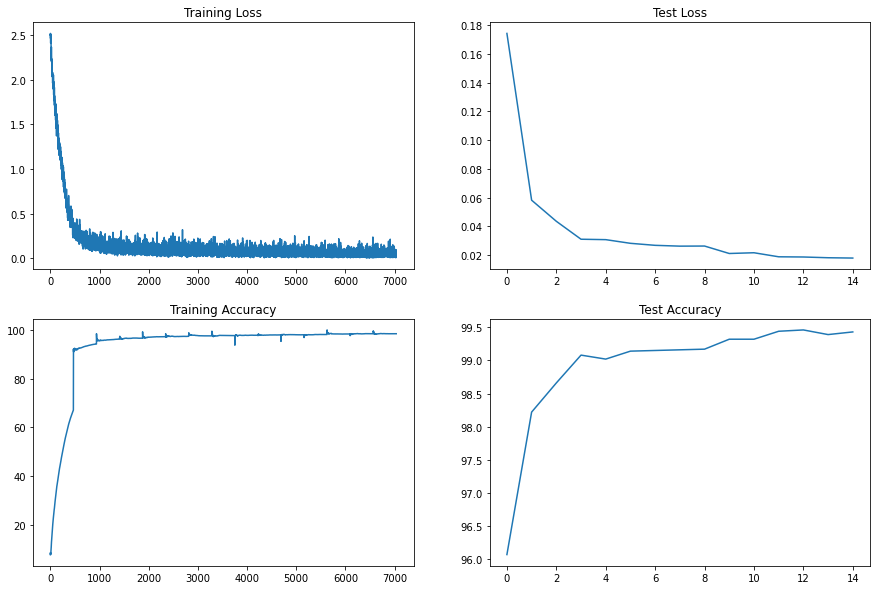

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")